In [1]:
#connect to colab
!git clone https://github.com/jkohler-u/Denoise_tf.git
import sys
sys.path.append('/content/Denoise_tf')

Cloning into 'Denoise_tf'...
remote: Enumerating objects: 53, done.
remote: Counting objects: 100% (53/53), done.
remote: Compressing objects: 100% (51/51), done.
remote: Total 53 (delta 27), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (53/53), 4.76 MiB | 2.24 MiB/s, done.


In [3]:
#our own pyfiles
import preprocessing
import unet
import postprocessing

In [4]:
%load_ext tensorboard

In [6]:
#working with files
from zipfile import ZipFile
from google.colab import drive
import os

filename = 'a1'

# Mount your Google Drive
drive.mount('/content/drive')

# Change the working directory to your Drive
os.chdir('/content/drive/MyDrive')

# Open the zipfile and extract its contents to memory
with ZipFile('CleanSpeech_training.zip', 'r') as zip_file:
  zip_file.extractall(filename)

filename = 'a2'

# Open the zipfile and extract its contents to memory
with ZipFile('NoisySpeech_training.zip', 'r') as zip_file:
  zip_file.extractall(filename)

Mounted at /content/drive


In [8]:
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf


#load the data 
train_noisy = preprocessing.prepare_data('a2')
train_clean = preprocessing.prepare_data('a1')
train_noisy = preprocessing.make_same(train_noisy, 196500)
train_clean = preprocessing.make_same(train_clean, 196500)


# Turn all the data into complex spectrograms
clean_spec = preprocessing.spectrogram(np.array(train_clean))
noisy_spec = preprocessing.spectrogram(np.array(train_noisy))

#convert the data into a tf dataset
tf_dataset = tf.data.Dataset.from_tensor_slices((noisy_spec, clean_spec))

# Calculate the total number of samples in the dataset
num_samples = tf.data.experimental.cardinality(tf_dataset).numpy()

# Shuffle the dataset
tf_dataset = tf_dataset.shuffle(num_samples)

#randomly split the dataset into train and test sets
train_size = int(0.8 * num_samples)
test_size = num_samples - train_size
train_dataset = tf_dataset.take(train_size)
test_dataset = tf_dataset.skip(train_size)

#batch
batch_size = 10
train_dataset = train_dataset.batch(batch_size)
test_dataset = test_dataset.batch(batch_size)



/content/Denoise_tf/preprocessing.py:49: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


In [ ]:
'''libaries'''


#general

# audio processing/display
import soundfile as sf
import IPython
from scipy.io.wavfile import read
import librosa.display
from sklearn.model_selection import train_test_split


from tensorflow.keras import layers
from tensorflow.keras.models import Model
import tensorflow_io as tfio




In [9]:
'''fit function'''
#tf
import datetime
import tensorflow as tf
from tensorflow import keras

#added tensorboard log
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

unet.model.fit(
    train_dataset,
    epochs=20,
    shuffle=True,
    validation_data=test_dataset,
    callbacks=[tensorboard_callback],
)

Epoch 1/20
10/10 [==============================] - 59s 4s/step - loss: 0.4331 - val_loss: 0.3000
Epoch 2/20
10/10 [==============================] - 34s 4s/step - loss: 0.2678 - val_loss: 0.2853
Epoch 3/20
10/10 [==============================] - 31s 3s/step - loss: 0.2640 - val_loss: 0.2538
Epoch 4/20
10/10 [==============================] - 32s 3s/step - loss: 0.2582 - val_loss: 0.2411
Epoch 5/20
10/10 [==============================] - 31s 3s/step - loss: 0.2618 - val_loss: 0.2340
Epoch 6/20
10/10 [==============================] - 31s 3s/step - loss: 0.2478 - val_loss: 0.2547
Epoch 7/20
10/10 [==============================] - 30s 3s/step - loss: 0.2561 - val_loss: 0.2649
Epoch 8/20
10/10 [==============================] - 31s 3s/step - loss: 0.2570 - val_loss: 0.2241
Epoch 9/20
10/10 [==============================] - 30s 3s/step - loss: 0.2542 - val_loss: 0.2610
Epoch 10/20
10/10 [==============================] - 31s 3s/step - loss: 0.2336 - val_loss: 0.2536
Epoch 11/20
10/10 [

In [35]:
# Convert tf dataset back to numpy arrays
prediciton, noisy, clean = postprocessing.get_one_of_each(train_dataset)


#prediction_for_rest = prediction_for_rest.take(1)
pred = (unet.model.predict(prediciton.batch(1)))
pred = tf.squeeze(pred)

(128, 768)


Text(0.5, 1.0, 'prediction')

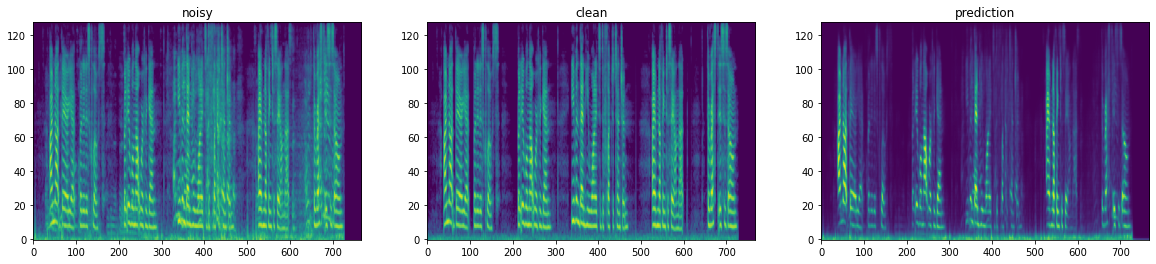

In [48]:
import matplotlib.pyplot as plt

f, axarr = plt.subplots(1,3, figsize=(20,4))
axarr[0].imshow(noisy, aspect='auto', origin='lower', cmap='viridis')
axarr[0].set_title("noisy")
axarr[1].imshow(clean, aspect='auto', origin='lower', cmap='viridis')
axarr[1].set_title("clean")
axarr[2].imshow(pred, aspect='auto', origin='lower', cmap='viridis')
axarr[2].set_title("prediction")


In [44]:
import IPython
import soundfile as sf
n = postprocessing.convert_to_audio(noisy)
c = postprocessing.convert_to_audio(clean)
p = postprocessing.convert_to_audio(pred)

#display audio
sr = 16000
sf.write('noisy.wav', n, sr)
sf.write('clean.wav', c, sr)
sf.write('pred.wav', p, sr)

IPython.display.Audio('noisy.wav')

In [42]:
IPython.display.Audio('clean.wav')

In [45]:
IPython.display.Audio('pred.wav')

In [ ]:
%tensorboard --logdir logs/fit